In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing necessary packages**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## **2. Load the Image Training and Validation Datasets**

### i. Get the Image Dataset Paths

In [ ]:
train_dataset_path = '/content/drive/MyDrive/FakevsReal/FakevsReal/train'
validation_dataset_path = '/content/drive/MyDrive/FakevsReal/FakevsReal/Validation'

### ii. Load Image Datasets and Apply Augmentations
Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [ ]:
IMG_WIDTH = 175
IMG_HEIGHT = 175
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.1,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 2634 images belonging to 2 classes.


Loading the validation dataset.

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1116 images belonging to 2 classes.


### iii. Get the Label Mappings
The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : fake
1 : real


## **3. Plotting Sample Training Image**s

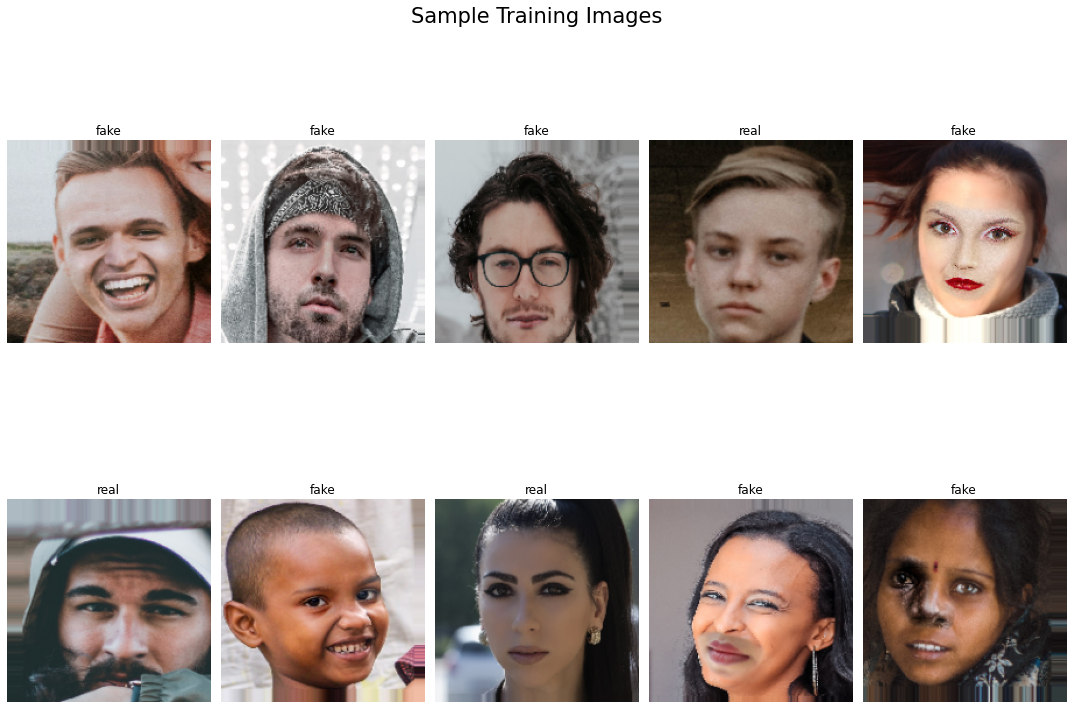

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


## **4. Training a EfficientNetV2B2 Model**
### i. Create a EfficientNetV2B2 Model

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(175,175,3),
                     include_preprocessing=True

                     )

base_model.trainable=True

In [ ]:
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 6, 6, 1408)       8769374   
 al)                                                             
                                                                 
 batch_normalization (BatchN  (None, 6, 6, 1408)       9856      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               721408    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

### ii. Defining Callbacks
A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

a. Reduce Learning Rate on Plateau
Is used to reduce the learning rate when a metric has stopped improving.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      # tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      # tf.keras.metrics.F1Score(name='F1'),
      tfa.metrics.F1Score(num_classes= 2,name="f1_Score")

    
]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### iii. Defining the Optimizer

In [ ]:
optimizer = Adam(learning_rate=0.001)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

### iv. Compile the Model

In [ ]:
# cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=METRICS)

### v. Training the Model

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=25,
                    validation_data=validation_generator,
                    validation_steps=2,
                    epochs=75,verbose = 2,
                    callbacks=[reduce_lr])

Epoch 1/75
25/25 - 44s - loss: 0.7097 - accuracy: 0.5604 - precision: 0.5604 - recall: 0.5604 - auc: 0.5785 - f1_Score: 0.5300 - val_loss: 0.7275 - val_accuracy: 0.4062 - val_precision: 0.4062 - val_recall: 0.4062 - val_auc: 0.4458 - val_f1_Score: 0.2889 - lr: 0.0010 - 44s/epoch - 2s/step
Epoch 2/75
25/25 - 16s - loss: 0.7130 - accuracy: 0.5213 - precision: 0.5213 - recall: 0.5213 - auc: 0.5265 - f1_Score: 0.5068 - val_loss: 0.6983 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938 - val_auc: 0.6372 - val_f1_Score: 0.3725 - lr: 0.0010 - 16s/epoch - 637ms/step
Epoch 3/75
25/25 - 16s - loss: 0.7035 - accuracy: 0.5375 - precision: 0.5375 - recall: 0.5375 - auc: 0.5587 - f1_Score: 0.4982 - val_loss: 0.7117 - val_accuracy: 0.5469 - val_precision: 0.5469 - val_recall: 0.5469 - val_auc: 0.5842 - val_f1_Score: 0.3535 - lr: 0.0010 - 16s/epoch - 640ms/step
Epoch 4/75
25/25 - 17s - loss: 0.7246 - accuracy: 0.4961 - precision: 0.4961 - recall: 0.4961 - auc: 0.5089 - f1_Score: 0.47

## **5. Plotting the Model Metrics**
### i. Plotting training and validation accuracy, loss and learning rate

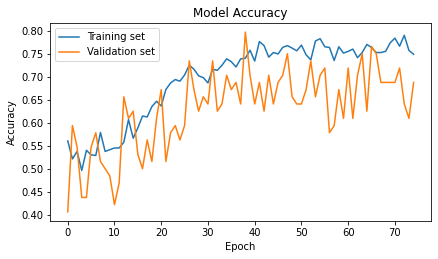

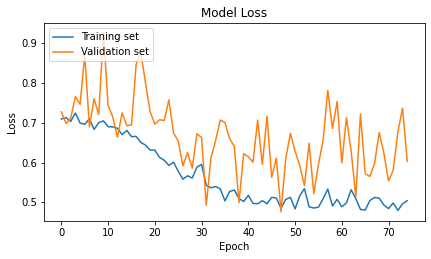

In [ ]:

plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']
learning_rate = history.history['lr']
print("Train Accuracy:" ,train_accuracy)
print("val Accuracy:" ,val_accuracy)
print("Train Loss:" ,train_loss)
print("val Loss:" ,val_loss)




Train Accuracy: [0.5604113340377808, 0.5212500095367432, 0.5375000238418579, 0.49614396691322327, 0.5400000214576721, 0.5299999713897705, 0.5287500023841858, 0.5787500143051147, 0.5375000238418579, 0.5412499904632568, 0.5450000166893005, 0.5450000166893005, 0.5575000047683716, 0.6066837906837463, 0.5662500262260437, 0.5886889696121216, 0.6143959164619446, 0.612500011920929, 0.6349999904632568, 0.6465295553207397, 0.6362468004226685, 0.6722365021705627, 0.6862499713897705, 0.6937500238418579, 0.6902313828468323, 0.7037500143051147, 0.7249357104301453, 0.7162500023841858, 0.7017995119094849, 0.6979434490203857, 0.6863753199577332, 0.7162500023841858, 0.7137500047683716, 0.7249357104301453, 0.7387499809265137, 0.7325000166893005, 0.7210797071456909, 0.7387499809265137, 0.7400000095367432, 0.7574999928474426, 0.73393315076828, 0.7762500047683716, 0.7674999833106995, 0.7425000071525574, 0.7524999976158142, 0.7493573427200317, 0.7637500166893005, 0.7674999833106995, 0.7622107863426208, 0.756

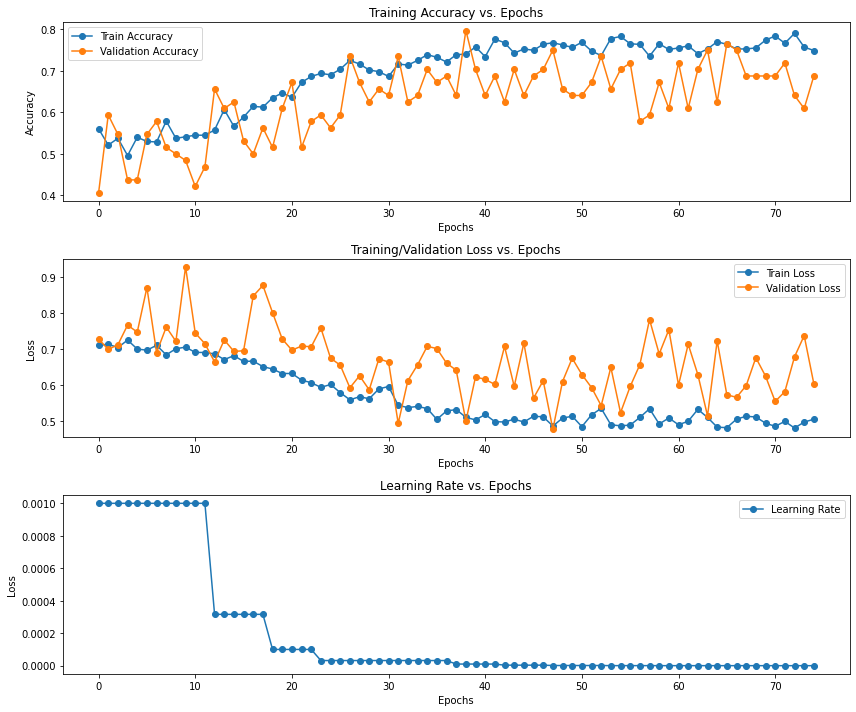

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

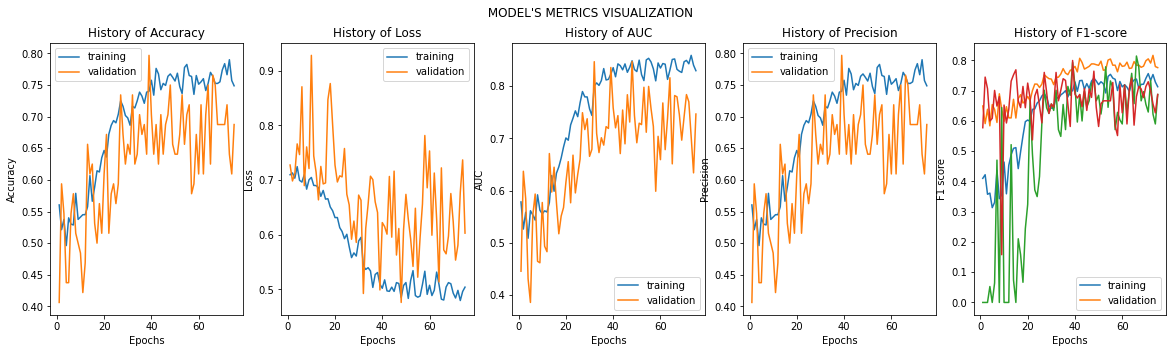

In [ ]:

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1_Score,val_f1_Score):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1_Score) + 1), f1_Score)
    ax5.plot(range(1, len(val_f1_Score) + 1), val_f1_Score)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    
import numpy as np
# f1_s= np.mean(history.history['f1_Score'])
# val_f1_s= np.mean(history.history['val_f1_Score'])
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              #  f1_s,val_f1_s

                , history.history['f1_Score'],history.history['val_f1_Score']
              )


## 6. Testing the Model on Test Set
Testing the model on the validation dataset because a seperate dataset for testing is not available.


In [ ]:
test_dataset = '/content/drive/MyDrive/FakevsReal/FakevsReal/Validation'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 1116 images belonging to 2 classes.


## 7. Model Prediction on the Test Dataset

In [ ]:
predictions = model.predict(test_generator)

35/35 [==============================] - 25s 637ms/step


In [ ]:
train_loss, train_accuracy, train_precision, train_recall, train_auc, train_F1_Score = model.evaluate(train_generator, batch_size=BATCH_SIZE)
print("done")

83/83 [==============================] - 46s 551ms/step - loss: 0.4463 - accuracy: 0.8003 - precision: 0.8003 - recall: 0.8003 - auc: 0.8749 - f1_Score: 0.7993
done


In [ ]:
print(f"Train Loss:     {train_loss}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train AUC: {train_auc}")
print(f"Train F1_Score: {np.mean(train_F1_Score)}")

Train Loss:     0.4463393986225128
Train Accuracy: 0.8003036975860596
Train Precision: 0.8003036975860596
Train Recall: 0.8003036975860596
Train AUC: 0.8749318718910217
Train F1_Score: 0.7992812395095825


In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_F1_Score = model.evaluate(test_generator, batch_size=BATCH_SIZE)

35/35 [==============================] - 14s 399ms/step - loss: 0.6262 - accuracy: 0.6711 - precision: 0.6711 - recall: 0.6711 - auc: 0.7350 - f1_Score: 0.6707


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1_Score: {np.mean(test_F1_Score)}")

Test Loss:     0.626198947429657
Test Accuracy: 0.6711469292640686
Test Precision: 0.6711469292640686
Test Recall: 0.6711469292640686
Test AUC: 0.734957754611969
Test F1_Score: 0.6706579923629761


## **8. Plotting the Classification Metrics**
### i. Confusion Matrix

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

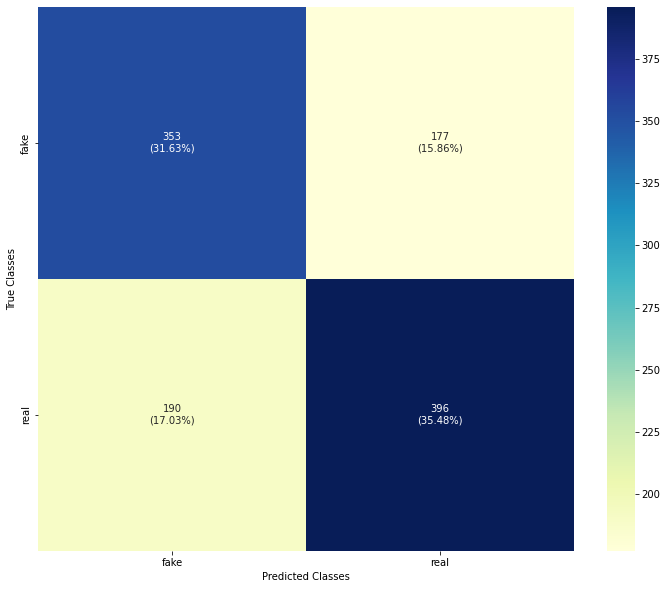

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

        fake       0.65      0.67      0.66       530
        real       0.69      0.68      0.68       586

    accuracy                           0.67      1116
   macro avg       0.67      0.67      0.67      1116
weighted avg       0.67      0.67      0.67      1116



In [ ]:
A=history.history['accuracy']
A_v=history.history['val_accuracy']
L=history.history['loss']
L_v=history.history['val_loss']
Auc=history.history['auc']
Auc_v=history.history['val_auc']
P=history.history['precision']
P_v=history.history['val_precision']
F1=history.history['f1_Score']
F1_v=history.history['val_f1_Score']
import pandas as pd
data_to_submit = pd.DataFrame({
    'accuracy':A,
    'val_accuracy':A_v,
    'loss': L,
    'val_loss': L_v,
    'auc':Auc,
    'val_auc':Auc_v,
    'precision':P,
    'val_precision':P_v,
    'f1_score':F1,
    'val_f1_score':F1_v
})
data_to_submit.to_csv('EffectiveNetV2B3.csv', index = False)